In [1]:
import matplotlib.pyplot as plt
import gzip
import json
from tqdm import tqdm
import os
from multiprocessing import Pool

In [10]:
def load_network(path):
    print("Loading network:")
    fnames = os.listdir(path)
    fnames = [f for f in fnames if f.endswith(".gz")]
    data = dict()
    for fname in tqdm(fnames, leave=True):
        with gzip.open(path + fname, "rb") as fh:
            for line in fh:
                user_meta = json.loads(line)
                uid = fname.split("_")[0]
                data[uid] = user_meta
    return data


def load_botscores(botscores_path):
    print("Loading bot scores:")
    account_bot_scores = dict()
    with gzip.open(botscores_path, "r") as fp:
        for l in tqdm(fp, leave=True):
            uid, bot_score = l.decode("utf-8").split("\t")
            account_bot_scores[uid] = bot_score.strip()
    return account_bot_scores


def load_profiles(path):
    print("Loading the profiles:")
    profiles = dict()
    with gzip.open(path, "r") as fp:
        for l in tqdm(fp, leave=True):
            profile = json.loads(l)
            profiles[profile["id_str"]] = profile
    return profiles


def load_account_statistics(path):
    print("Loading politicians profiles:")
    profiles = dict()
    with gzip.open(path, "r") as fp:
        for l in tqdm(fp, leave=True):
            profile = json.loads(l)
            profiles[profile["id"]] = profile

    return profiles


def load_user_to_party(path):
    print("Loading the user2party file!")
    with open(path, "r") as fp:
        return json.load(fp)

def get_bots(user, scores, entity):
    bots = []

    for i in user[entity]:
        if i in scores:
            if float(scores[i]) >= 0.5:
                bots.append(i)

    return bots


def shared_items_count(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2))


In [11]:
network = load_network("/cta/DATASETS/Secim2023Data/networks/edges/2022-09/")
political_network = load_account_statistics("/cta/DATASETS/Secim2023Data/profiles/account_statistics_2022-09.jsons.gz")
profiles = load_profiles("/cta/DATASETS/Secim2023Data/networks/nodes/follower_profiles_2022-09.jsons.gz") 

account_botscores = load_botscores("/cta/DATASETS/ElectionAnalysis/twitter_networks/botscores_2022-09.tsv.gz")
user2party = load_user_to_party("/cta/DATASETS/ElectionAnalysis/user2party.json") 

Loading network:


100%|██████████| 936/936 [00:55<00:00, 16.75it/s]


Loading politicians profiles:


934it [00:01, 569.09it/s]


Loading the profiles:


37271820it [06:08, 101059.76it/s]


Loading bot scores:


37270001it [00:48, 767175.98it/s]

Loading the user2party file!


In [4]:
PARTY_COLORS = {
    "AKP": "#FF8700",
    "MHP": "#57585A",
    "CHP": "#EB2229",
    "IYI": "#30D5C8",
    "DEVA": "#008DBC",
    "DP": "#eeeeee",
    "GELECEK": "#2db34a",
    "SAADET": "#CF3338",
    "HDP": "#90268F",
}

In [5]:
network_bots = dict()
for i in tqdm(network):
    network_bots[i] = get_bots(network[i], account_botscores, entity='followers')

users_ids = list(network_bots.keys())
items = []
for i in range(len(users_ids)):
    for j in range(i + 1, len(users_ids)):
        items.append((users_ids[i], users_ids[j]))

100%|██████████| 936/936 [04:03<00:00,  3.85it/s]


In [7]:
def get_edge_props(idx):
    id1, id2 = idx[0], idx[1]

    if id1 not in political_network or id2 not in political_network:
        return None

    screen_name_1 = political_network[id1]["screen_name"].lower()
    id1_party = user2party.get(screen_name_1, "")
     
    screen_name_2 = political_network[id2]["screen_name"].lower()
    id2_party = user2party.get(screen_name_2, "")
     
    return {
        "node1": {'uid': id1, "party": id1_party, "name": screen_name_1, "#followers": len(network[id1]['followers']), "#bots_followers": len(network_bots[id1])},  
        "node2": {'uid': id2, "party": id2_party, "name": screen_name_2, "#followers": len(network[id2]['followers']), "#bots_followers":  len(network_bots[id2])},  
        "edge": {
            "#shared_bot_followers": shared_items_count(
                network_bots[id1],
                network_bots[id2],
            ),
            "#shared_followers": shared_items_count(
                network[id1]['followers'],
                network[id2]['followers'],
            ),
        },
    }

with Pool(12) as pool:
    edge_props = pool.map(get_edge_props, items)

edge_props = [ep for ep in edge_props if ep is not None]

In [40]:
in_party_sharedbots = {
    party: [] for party in list(PARTY_COLORS.keys())
}

for edge_prop in edge_props:
    if edge_prop['node1']['party'] == edge_prop['node2']['party']:
        if edge_prop['node1']['party'] in in_party_sharedbots:
            if edge_prop['edge']["#shared_followers"] != 0:
                p = edge_prop['edge']['#shared_bot_followers'] / edge_prop['edge']["#shared_followers"]
                in_party_sharedbots[edge_prop['node1']['party']].append(p)


In [41]:
in_party_sharedbots.keys()

dict_keys(['AKP', 'MHP', 'CHP', 'IYI', 'DEVA', 'DP', 'GELECEK', 'SAADET', 'HDP'])

In [2]:
# with open("edge_props-politicians.json", "w") as fh:
#     json.dump(edge_props, fh, indent=4)

with open("edge_props-politicians.json", "r") as fh:
    edge_props = json.load(fh)

In [3]:
# with open("in_party_sharedbots.json", "w") as fh:
#     json.dump(in_party_sharedbots, fh, indent=4)
with open("in_party_sharedbots.json", "r") as fh:
    in_party_sharedbots = json.load(fh)

In [5]:
import numpy as np
import scipy.stats as sts

## Plot Bot Scores Density

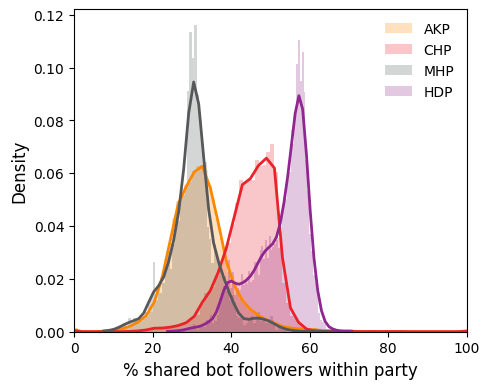

In [65]:
plt.style.use('default')
fig = plt.figure(figsize=(5,4))
party_list = ["AKP", "CHP", 'MHP', "HDP"]

for index, pname in enumerate(party_list):
    samples  = np.array(in_party_sharedbots[pname]) * 100
    h,e = np.histogram(samples, bins=100, density=True)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), color=PARTY_COLORS[pname], align='edge', label=pname,alpha=0.25)

    rkde = sts.gaussian_kde(samples)
    plt.plot(x, rkde.pdf(x), '-', c=PARTY_COLORS[pname], lw=2,)


plt.xlim(0,100)
plt.xlabel("% shared bot followers within party",fontsize=12)
plt.ylabel("Density",fontsize=12) 
plt.legend(loc='upper right',frameon=False)
plt.tight_layout()
plt.savefig("shared_bot_followers_density.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [14]:
edge_props[:1]

[{'node1': {'uid': '2491561381',
   'party': 'AKP',
   'name': 'barisaydin06',
   '#followers': 10784,
   '#bots_followers': 3252},
  'node2': {'uid': '405144728',
   'party': 'CHP',
   'name': 'fikretsahin10',
   '#followers': 21166,
   '#bots_followers': 10721},
  'edge': {'#shared_bot_followers': 162, '#shared_followers': 292}}]

## Plot BotScores Violin Distribution 

In [12]:
def get_bot_scores(user, scores, entity):
    bot_scores = []

    for i in user[entity]:
        if i in scores:
            bot_scores.append(float(scores[i]))

    bot_scores.sort()
    return bot_scores   

network_bot_scores = dict()
for i in tqdm(network):
    network_bot_scores[i] = get_bot_scores(network[i], account_botscores, entity='followers')

100%|██████████| 936/936 [03:08<00:00,  4.97it/s]


In [13]:
nodes = dict()
for edge_prop in edge_props:
    nodes[edge_prop['node1']["uid"]] = edge_prop['node1'] 
    nodes[edge_prop['node2']["uid"]] = edge_prop['node2'] 

In [14]:
def sort_by_median(probs):
    if len(probs) == 0:
        return 0
    if len(probs) % 2 == 0:
        return (probs[len(probs)//2] + probs[(len(probs)//2) - 1]) / 2
    else:    
        return probs[len(probs)//2] 

politicians = list(nodes.items())
politicians.sort(key=lambda x: sort_by_median(network_bot_scores[x[0]]),reverse=True)

In [15]:
politicians[0]

('2601816284',
 {'uid': '2601816284',
  'party': 'GELECEK',
  'name': 'mnedimyamali',
  '#followers': 195660,
  '#bots_followers': 159267})

In [34]:
top_n = 40
data = []
data_colors = []
x_labels = []
i = 0
while top_n > len(data):
    uid = politicians[i][0]
    if politicians[i][1]['party'] in PARTY_COLORS:
        data.append(np.array(network_bot_scores[uid]) * 100)
        data_colors.append(PARTY_COLORS.get(politicians[i][1]['party']))
        x_labels.append(politicians[i][1]['name'])
        
    i += 1

In [35]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def get_percentiles(data, percentiles=[25, 50, 75]):
    quartile1s = []  
    medianss = []  
    quartile3s = []  
    for items in data:
        quartile1, medians, quartile3 = np.percentile(items,percentiles,axis=0)
        quartile1s.append(quartile1)
        medianss.append(medians)
        quartile3s.append(quartile3)
    return np.array(quartile1s), np.array(medianss), np.array(quartile3s)

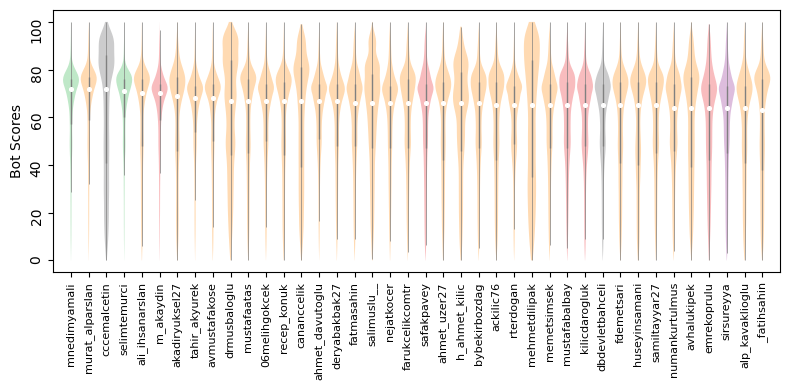

In [37]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.set_ylabel('Bot Scores')
parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths=0.90)

for index, part in enumerate(parts['bodies']):
    part.set_facecolor(data_colors[index])

quartile1, medians, quartile3 = get_percentiles(data, [25, 50, 75])
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=7, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='0.5', linestyle='-', lw=1)
ax.vlines(inds, whiskers_min, whiskers_max, color='0.5', linestyle='-', lw=0.5)
 
ax.set_xticks(np.arange(1, len(x_labels) + 1), labels=x_labels,rotation=90,fontsize=8)
 
for ytick in ax.get_yticklabels():
    ytick.set_rotation(90)


plt.xlim(0, len(x_labels) + 1)
plt.tight_layout()
plt.savefig("bot_followers_violin_plot_v2.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()  

## Plot most bot and human followers

In [16]:
sorted_politicians = sorted(politicians.copy(), key=lambda x:x[1]['#followers'], reverse=True) # sort by number of followers

In [38]:
top_n = 40
new_data = []
data_colors = []
x_labels = []
i = 0
while top_n > len(new_data):
    uid = sorted_politicians[i][0]
    if sorted_politicians[i][1]['party'] in PARTY_COLORS:
        n_followers = sorted_politicians[i][1]["#followers"]
        n_bot_followers = sorted_politicians[i][1]["#bots_followers"]
        n_human_followers = n_followers - n_bot_followers

        new_data.append((n_bot_followers,n_human_followers,n_followers))
        data_colors.append(PARTY_COLORS.get(sorted_politicians[i][1]['party']))
        x_labels.append(sorted_politicians[i][1]['name'])
        
    i = i + 1
new_data = np.array(new_data)


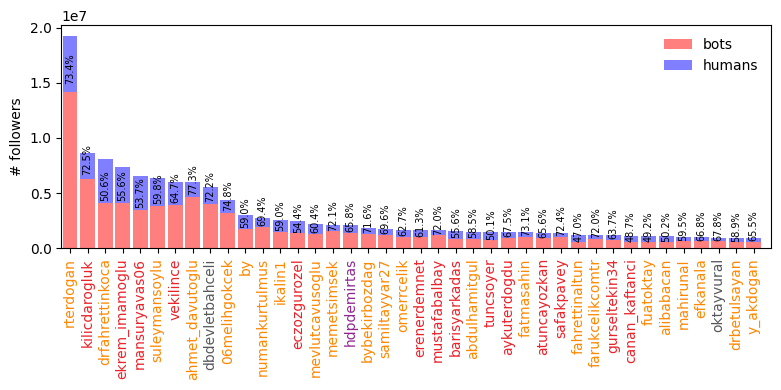

In [41]:
plt.style.use('default')

width = 0.85 

fig, ax = plt.subplots(figsize=(8,4))

bar1 = ax.bar(x_labels, new_data[:,0], width, color='r', label='bots',alpha=0.5)
bar2 = ax.bar(x_labels, new_data[:,1], width, color='b', label='humans',bottom=new_data[:,0],alpha=0.5)
    
counter = 0
for rect in bar1 + bar2:
    height = (new_data[counter][0] / new_data[counter][2]) * 100 
    h = rect.get_height()
    plt.text(x=(rect.get_x() + rect.get_width()/2 ), y=new_data[counter][0] * 1.05,
            s="{:.1f}%".format(height),
            ha='center',
            va='bottom',
            rotation=90,
            fontsize=7
            )
    counter += 1
    if counter == 40:
        break

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), data_colors):
    ticklabel.set_color(tickcolor)

ax.set_xticks(np.arange(0, len(x_labels)), labels=x_labels,rotation=90)

ax.set_ylabel("# followers")
ax.legend(frameon=False)
plt.xlim(-0.5, len(x_labels))
plt.tight_layout()
plt.savefig("followers_histogram.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


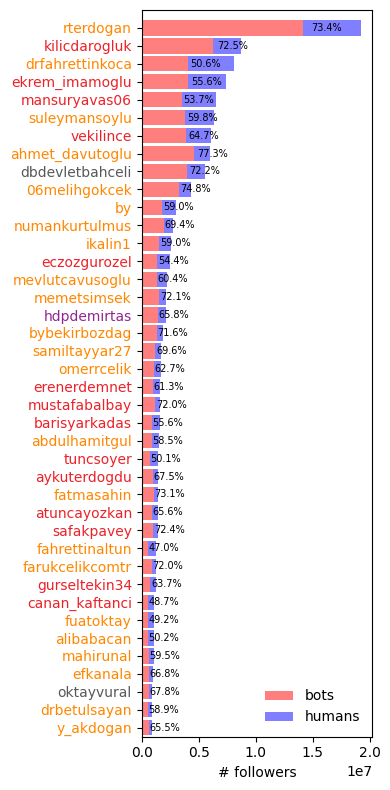

In [62]:
plt.style.use('default')

width = 0.85 

fig, ax = plt.subplots(figsize=(4,8))

bar1 = ax.barh(x_labels[::-1], new_data[:,0][::-1], width, color='r', label='bots',alpha=0.5)
bar2 = ax.barh(x_labels[::-1], new_data[:,1][::-1], width, color='b', label='humans',left=new_data[:,0][::-1],alpha=0.5)
    
counter = 0
reversed_data = new_data[::-1]
for rect in bar1 + bar2:
    height = (reversed_data[counter][0] / reversed_data[counter][2]) * 100 
    h = rect.get_height()
    w = rect.get_width()
    plt.text(
        x=reversed_data[counter][0] * 1.05, #   new_data[counter][0] * 1.05,
        y=(rect.get_y() + h/2 ), # (rect.get_y() + h/2 ),
            s="{:.1f}%".format(height),
            ha='left',
            va='center',
            rotation=0,
            fontsize=7
            )
    counter += 1
    if counter == 40:
        break

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), data_colors[::-1]):
    ticklabel.set_color(tickcolor)

ax.set_xlabel("# followers")
ax.legend(frameon=False)
plt.ylim(-0.5, len(x_labels))
plt.tight_layout()
plt.savefig("followers_histogram_v2.pdf", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Plot asymmetric  Heatmap

In [46]:
from collections import defaultdict

party_data = defaultdict(list)
for i in sorted_politicians:
    if i[1]['party'] in PARTY_COLORS:
        party = i[1]['party']
        party_data[party].append(i)

In [47]:
party_order = ["AKP","MHP","CHP","HDP"]

In [48]:
users = {}
index = 0
idx = []
for p in party_order:
    c = 0
    for user in party_data[p]:
        if user[1]['#followers'] >= 10000:
            users[user[0]] = (user[1],index) 
            index += 1
            c+=1
    idx.append(c)
idx = np.array(idx)
party_idx = idx.cumsum()
party_idx

array([374, 440, 627, 720])

In [50]:
heatmap_matrix = np.zeros(shape=(len(users),len(users)))
heatmap_matrix[:] = np.nan
for edge in edge_props:
    if edge['node1']["uid"] in users and edge['node2']["uid"] in users:

        index1 = users[edge['node1']["uid"]][1]
        index2 = users[edge['node2']["uid"]][1]
        if index1 == index2:
            heatmap_matrix[index1][index2] = np.nan
        elif edge["edge"]["#shared_followers"] != 0:
            heatmap_matrix[index1][index2] = edge["edge"]["#shared_bot_followers"] / edge["edge"]["#shared_followers"]
            heatmap_matrix[index2][index1] = edge["edge"]["#shared_bot_followers"] / edge["edge"]["#shared_followers"]

In [51]:
heatmap_sharedfollowrs_matrix = np.zeros(shape=(len(users),len(users)))
heatmap_sharedfollowrs_matrix[:] = np.nan
for edge in edge_props:
    if edge['node1']["uid"] in users and edge['node2']["uid"] in users:

        index1 = users[edge['node1']["uid"]][1]
        index2 = users[edge['node2']["uid"]][1]
        if index1 == index2:
            heatmap_sharedfollowrs_matrix[index1][index2] = np.nan
        elif edge["edge"]["#shared_followers"] != 0:
            heatmap_sharedfollowrs_matrix[index1][index2] = edge["edge"]["#shared_followers"]
            heatmap_sharedfollowrs_matrix[index2][index1] = edge["edge"]["#shared_followers"]

In [52]:
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sns.set_theme(style="white")

In [53]:
party_idx

array([374, 440, 627, 720])

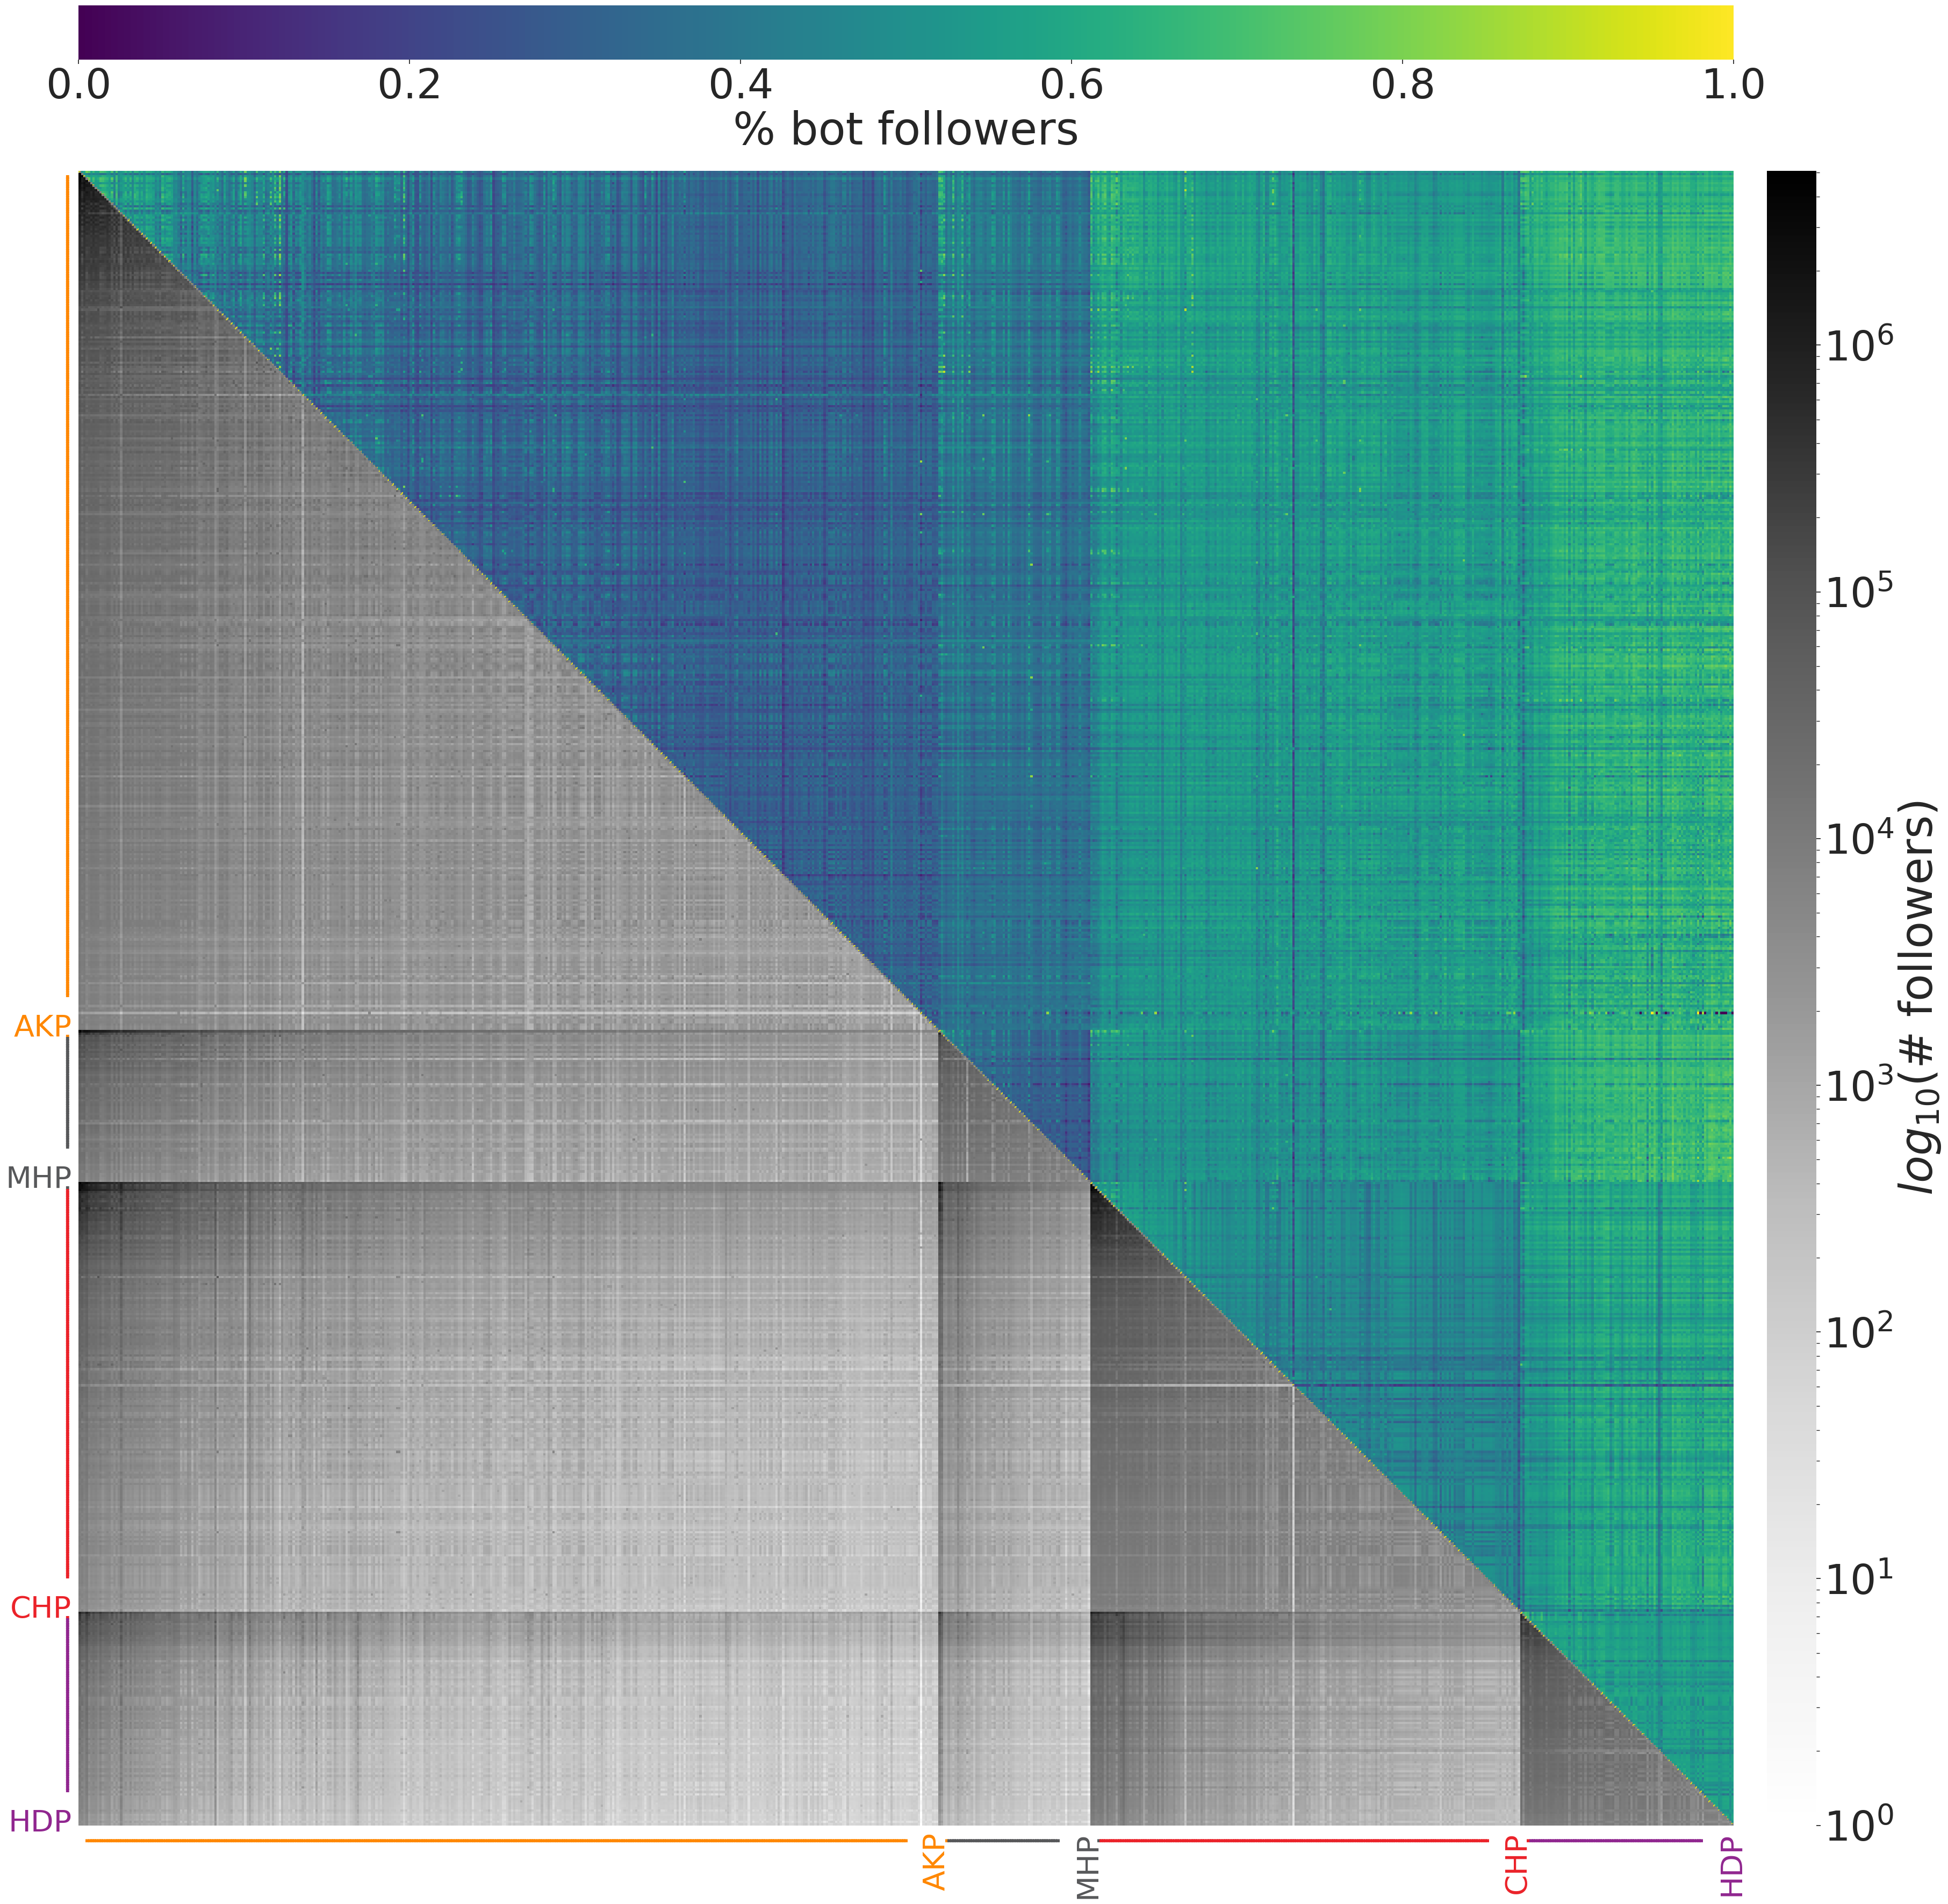

In [54]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.set(font_scale=5)
cax1 = inset_axes(ax,
                 width="100%",  # width: 40% of parent_bbox width
                 height="3%",  # height: 10% of parent_bbox height
                 loc='upper center',
                 bbox_to_anchor=(0, 0, 1, 1.1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )


sns.heatmap(heatmap_matrix, mask=np.tril(heatmap_matrix),
            cmap='viridis',square=True, linewidths=0, ax=ax,
            cbar_ax=cax1,
            cbar_kws = {'orientation': 'horizontal', 'label': '% bot followers'},
            # vmax=(heatmap_matrix[heatmap_matrix!= np.nan]).max(), vmin=(heatmap_matrix[heatmap_matrix!= np.nan]).min(),
            )
 
cax2 = inset_axes(ax,
                 width="3%",  # width: 40% of parent_bbox width
                 height="100%",  # height: 10% of parent_bbox height
                 loc='center right',
                 bbox_to_anchor=(0.05, 0, 1, 1), # [left, bottom, width, height]
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
sns.heatmap(heatmap_sharedfollowrs_matrix, mask=np.triu(heatmap_sharedfollowrs_matrix), 
            cmap='Greys', square=True, linewidths=0, ax=ax,
            norm=LogNorm(),
            cbar_ax=cax2,
            cbar_kws = {'orientation': 'vertical', 'label': '$log_{10}$(# followers)'},
            # vmax=np.log10((heatmap_sharedfollowrs_matrix[heatmap_sharedfollowrs_matrix!= np.nan]).max(), vmin=0.1, 
            )


# the following lines color and hatch the axes background, only the diagonals are visible
new_idx = list(range(party_idx[-1]))
new_labels = [[p] * i for i,p in zip(idx,party_order)]
new_labels = sum(new_labels,[])

ax.tick_params(axis='both', which='major', labelsize=40)

ax.patch.set_facecolor('grey')
ax.patch.set_edgecolor('yellow')
ax.patch.set_hatch('xx')

labels = []
counter = 0
pad = 8
for pindex in idx:
    labels.extend(["."] * (pindex- (2 * pad + 1)))
    labels.extend([''] * 2 * pad)
    labels.append(party_order[counter])
    counter+=1

ax.set_xticks(np.arange(0, party_idx[-1]), labels=labels,rotation=90)
ax.set_yticks(np.arange(0, party_idx[-1]), labels=labels)

counter = 0
xticks = ax.get_xticklabels()
yticks = ax.get_yticklabels()
for i in range(len(xticks)):
    xticks[i].set_color(PARTY_COLORS[party_order[counter]])
    yticks[i].set_color(PARTY_COLORS[party_order[counter]])
    if i in party_idx:
        counter += 1
 
plt.savefig("heatmap_plot_asymmetric.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()